In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from numba import njit

In [2]:
def random_cheby(x, y, n=5, gamma=1.0):
    dims = (n,n)
    coef = (np.random.random(dims) * 2.0 - 1.0)
    coef*= np.fromfunction(lambda x,y : np.where(x+y<n, 1.0/(x+y+1)**gamma, 0.0), dims)
    return np.polynomial.chebyshev.chebgrid2d(x,y,coef)

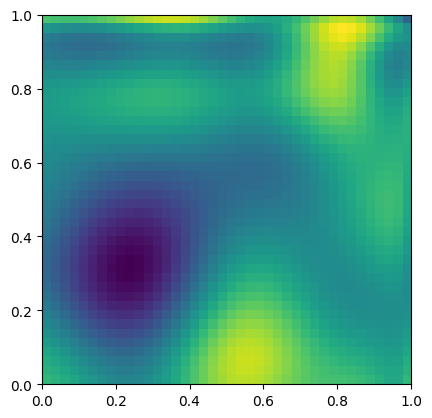

In [3]:
x = np.linspace(0, 1, 40)
z = random_cheby(x,x,15,0.0)
plt.imshow(z, extent=(0.0,1.0,0.0,1.0), origin='lower')
plt.show()

In [4]:
class LaplSolver:
    # -Δu = c*u + f
    def __init__(self, h, c=0.0, eps=1e-6):
        self.c = c
        self.eps = eps
        self.h = h

    @staticmethod
    @njit
    def iter(u, f, h, c):
        # Gauss-Seidel
        sx, sy = u.shape
        a  = 4.0 - c*h**2
        for i in range(1,sx-1):
            for j in range(1,sy-1):
                u[i,j] = (u[i-1,j] + u[i+1,j] + u[i,j-1] + u[i,j+1])/a + h**2*f[i,j]/a
        return u

    def solve(self, f, g, step_size=50, timeout=1000, init=None):
        # init RHS
        u = g.copy()
        if init is not None:
            u[1:-1, 1:-1] = init[1:-1, 1:-1]

        up = np.zeros_like(f)
        err = np.inf
        T = 0
        while err > self.eps:
            for i in range(step_size):
                up[:,:] = u[:,:]
                u = LaplSolver.iter(u, f, self.h, self.c)
            err = np.linalg.norm(u-up)/self.h
            print("T = {}, err = {}".format(T, err))
            T += 1
            if T > timeout or err > 1000.0:
                break
        return u, err

    def test(self, u, f):
        return -(u[:-2, 1:-1] + u[2:, 1:-1] + u[1:-1, :-2] + u[1:-1, 2:] - 4.0*u[1:-1, 1:-1])/self.h**2 - self.c*u[1:-1,1:-1] - f[1:-1, 1:-1]

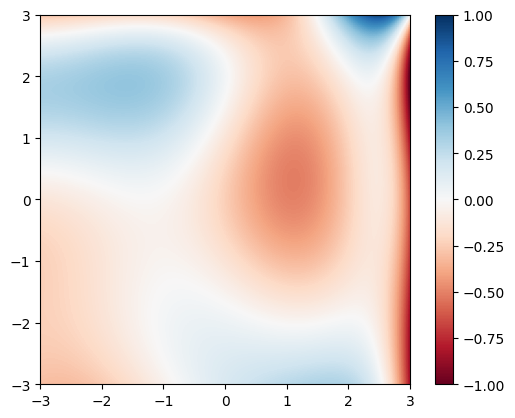

In [5]:
res = 200
s = (-3.0, 3.0)
h = (s[1]-s[0])/res
x = np.linspace(0.0, 1.0, res+1)
g = random_cheby(x, x, 10, -0.5)
g = g / np.abs(g).max()
f = np.zeros_like(g)

def draw(g):
    M = np.abs(g).max()
    plt.imshow(g, extent=(*s, *s), vmin = -M ,vmax = M, origin='lower', cmap='RdBu')
    plt.colorbar()
    plt.show()

draw(g)

### NN

In [6]:
def dict_search(array, i):
    N = len(array)
    if N == 1:
        return 0, i-array[0]

    midpoint = N//2
    if i < array[midpoint]:
        return dict_search(array[:midpoint], i)
    elif N > 2 and i < array[midpoint+1]:
        return midpoint, i - array[midpoint]
    else:
        Idx, idx = dict_search(array[midpoint:], i)
        return midpoint + Idx, idx

In [7]:
import os

from torch.utils.data import Dataset, DataLoader
from scipy.interpolate import RegularGridInterpolator

class LaplDataGen(Dataset):
    def __init__(self, bounds=(-3,3), res=60,
                 c=0.2, eps=1e-6, fn=None):
        if fn is not None:
            self.load(fn)
        else:
            self.setup_grid(bounds, res)
            self.setup_solver(c, eps)
            self.gs = []
            self.us = []
            self.ps = []
            self.vs = []
            self.idxs = []
            self.total = 0

    def setup_grid(self, bounds=(-3,3), res=60):
        """setup_grid(self, bounds=(-3,3), res=60)"""
        self.bounds = (float(bounds[0]), float(bounds[1]))
        self.res = res
        try:
            self.setup_solver(self.c, self.eps)
        except AttributeError:
            pass

    def setup_solver(self, c=0.2, eps=1e-6):
        """setup_solver(self, c=0.2, eps=1e-6)"""
        self.h = (self.bounds[1]-self.bounds[0])/self.res
        self.c = c
        self.eps = eps
        self.solver = LaplSolver(h, c, eps)

    def drawsample_u(self, deg=5, gamma=0.5, **kwargs):
        """drawsample_u(self, deg, gamma, eps, **kwargs)"""
        err = np.inf
        x = np.linspace(0.0, 1.0, self.res+1)
        while err > self.eps:
            g = random_cheby(x,x, n=deg, gamma=gamma)
            u, err = self.solver.solve(np.zeros_like(g), g, init=g, **kwargs)
        return g,u

    def drawsample_p(self, u, n):
        """drawsample_p(self, u, n)"""
        x = np.linspace(self.bounds[0], self.bounds[1], self.res+1)
        ps = np.random.uniform(self.bounds[0], self.bounds[1], (2,n))
        vs = RegularGridInterpolator( (x, x), u.transpose(), method='cubic')(ps.transpose())
        return ps, vs

    def gen_dataset(self, numg, nump, deg=5, gamma=0.5, **kwargs):
        """gen_dataset(self, numg, nump, deg, gamma, **kwargs)"""
        if numg <= 0 or nump <= 0:
            raise ValueError("Number of samples generated cannot be negative.")

        for i in range(numg):
            print("g_{}:".format(i))
            g,u = self.drawsample_u(deg, gamma, **kwargs)
            self.gs.append(g)
            self.us.append(u)
            p,v = self.drawsample_p(u, nump)
            self.ps.append(p)
            self.vs.append(v)
            self.idxs.append(self.total)
            self.total+= nump

    def save(self, name):
        try:
            os.mkdir('dataset')
        except:
            pass
        np.savez_compressed("dataset/"+name+".npz",
            gs = self.gs,
            us = self.us,
            ps = np.concatenate(self.ps, 1),
            vs = np.concatenate(self.vs, 0),
            idxs = np.asarray(self.idxs),
            bounds = self.bounds,
            c = self.c,
            eps = self.eps,
            res = self.res
        )

    def load(self, name):
        npz = np.load("dataset/"+name+".npz")
        self.gs = list(npz['gs'])
        self.us = list(npz['us'])
        self.idxs = list(npz['idxs'])
        self.total = int(npz['ps'].shape[1])

        ps = npz['ps']
        idxs_w_last = self.idxs + [self.total]
        self.ps = [ps[..., idxs_w_last[i]:idxs_w_last[i+1]] for i in range(len(self.idxs))]
        vs = npz['vs']
        self.vs = [vs[..., idxs_w_last[i]:idxs_w_last[i+1]] for i in range(len(self.idxs))]

        self.bounds = (float(npz['bounds'][0]), float(npz['bounds'][1]))
        self.res = int(npz['res'])
        self.setup_solver(c = npz['c'], eps = npz['eps'])

    def get_raw_data(self, idx):
        return self.gs[idx], self.us[idx], self.ps[idx], self.vs[idx]

    @staticmethod
    def get_bc(g):
        return np.concatenate( (g[:,0], g[:,-1], g[0, 1:-1], g[-1,1:-1]) )

    @staticmethod
    def to_tensor(g, u, p, v):
        at_sensors = torch.from_numpy(LaplDataGen.get_bc(g))
        labels = torch.tensor(v).requires_grad_(True)
        return at_sensors, p, labels

    def __len__(self):
        return self.total

    def __getitem__(self, idx):
        I, i = dict_search(self.idxs, idx)
        g,u,ps,vs = self.get_raw_data(I)
        p = ps[:,i]
        v = vs[i]
        return self.to_tensor(g, u, p, v)

In [8]:
ldata = LaplDataGen(c=0.5, res=40)
ldata.gen_dataset(numg=10, nump=50)
ldata.gen_dataset(numg=5, nump=100, gamma=-0.5)

g_0:
T = 0, err = 3.055430377685929
T = 1, err = 2.056501016945522
T = 2, err = 1.4738140530687547
T = 3, err = 1.0821799571994881
T = 4, err = 0.8018260197595647
T = 5, err = 0.5958090766503608
T = 6, err = 0.44299571927001224
T = 7, err = 0.32934283671175707
T = 8, err = 0.24478538825938492
T = 9, err = 0.18189447259058017
T = 10, err = 0.13513737780351065
T = 11, err = 0.10038694636545455
T = 12, err = 0.0745663459463075
T = 13, err = 0.05538408055007585
T = 14, err = 0.041135040218561736
T = 15, err = 0.03055127038382285
T = 16, err = 0.02269031459757007
T = 17, err = 0.016851862352797075
T = 18, err = 0.012515634028353637
T = 19, err = 0.009295147256997368
T = 20, err = 0.006903331488682747
T = 21, err = 0.0051269676173455086
T = 22, err = 0.0038076939898255653
T = 23, err = 0.002827894884003043
T = 24, err = 0.0021002177991876576
T = 25, err = 0.0015597870569335796
T = 26, err = 0.0011584204881148685
T = 27, err = 0.0008603340469769071
T = 28, err = 0.0006389516066865575
T = 29, 

In [9]:
ldata.save('omg')
ldata2 = LaplDataGen(fn = 'omg')

In [10]:
def comp(a,b):
    if len(a) == len(b):
        for i in range(len(a)):
            if not (a[i]==b[i]).all():
                return False
        return True
    else:
        return False

print(comp(ldata.gs, ldata2.gs))
print(comp(ldata.us, ldata2.us))
print(comp(ldata.vs[0:-1], ldata2.vs[0:-1]))
print(comp(ldata.ps[0:-1], ldata2.ps[0:-1]))
print(comp(ldata.vs, ldata2.vs))
print(comp(ldata.ps, ldata2.ps))
print(ldata.bounds,ldata2.bounds)
print(ldata.c,ldata2.c)
print(ldata.res,ldata2.res)
print(ldata.eps,ldata2.eps)
print(ldata.h,ldata2.h)

True
True
True
True
True
True
(-3.0, 3.0) (-3.0, 3.0)
0.5 0.5
40 40
1e-06 1e-06
0.15 0.15


In [11]:
import matplotlib.cm as cm

def draw_with_points(g, p, v):
    M = np.abs(g).max()
    plt.imshow(g, extent=(*s, *s), vmin = -M ,vmax = M, origin='lower', cmap='RdBu')
    plt.colorbar()
    plt.scatter(p[0,:], p[1,:], s=20.0, c=[[0.0, 0.0, 0.0, 1.0]])
    plt.scatter(p[0,:], p[1,:], s=8.0, c=cm.RdYlBu( ((v/M)+1.0)/2.0 ))
    plt.show()

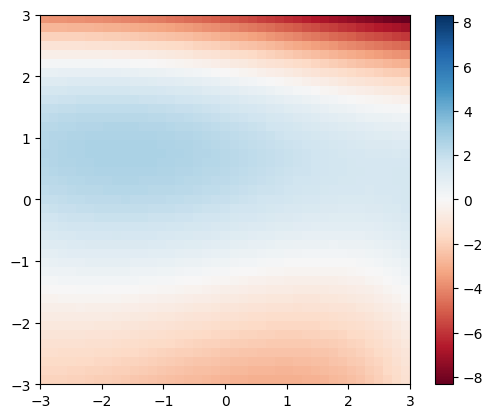

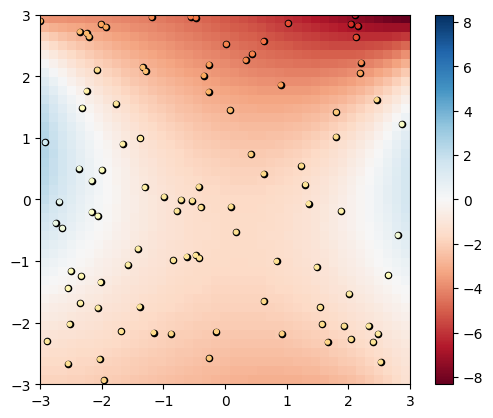

In [12]:
g,u,p,v = ldata.get_raw_data(12)
draw(g)
draw_with_points(u, p, v)

In [13]:
from torch import nn

class FFN(nn.Module):
    def __init__(self, indim=3721, depth=3, width=512, outdim=60):
        super().__init__()

        lin = [ nn.Linear(width, width) for i in range(depth) ]
        tanh = [ nn.Tanh() for i in range(depth) ]

        self.nn = nn.Sequential( *(
            [ nn.Linear(indim, width), nn.Tanh() ] +
            [ e for pair in zip(lin, tanh) for e in pair ] +
            [ nn.Linear(width, outdim) ]
            )
        )

    def forward(self, u):
        return self.nn(u)

class DeepONet(nn.Module):
    def __init__(self, sensors=240, dim=2, outdim=1, size=60,
                 branch_depth = 3, branch_width = 512, trunk_depth = 3, trunk_width=128):
        super().__init__()
        self.sensors = sensors
        self.dim = dim
        self.outdim = outdim
        self.funcdim = size
        self.branch = FFN(indim = sensors, outdim = size, width = branch_width, depth = branch_depth)
        self.trunk = FFN(indim = dim, outdim = size*outdim, width = trunk_width, depth = trunk_depth)

    def forward(self, u, p):
        bns = self.branch(u)
        tns = self.trunk(p)
        return torch.linalg.vecdot(bns,tns)

    def device(self):
        return self.branch.nn[0].weight.device

    def precompute(self, u):
        return self.apply_op(self.branch(u))

    def basis(self, i):
        ei = torch.zeros(self.funcdim, dtype = torch.float32)
        ei[i] = 1.0
        ei = ei.to(self.device())
        return self.apply_op(ei)

    def apply_op(self, coeffs):
        def aux(p):
            return torch.matmul(
                self.trunk(p),
                coeffs
            )
        return aux

In [14]:
deeponet = DeepONet(sensors = res*4).to("cuda")
deeponet.branch.nn[0].weight.dtype, deeponet.branch.nn[0].weight.device, list(deeponet.children())

(torch.float32,
 device(type='cuda', index=0),
 [FFN(
    (nn): Sequential(
      (0): Linear(in_features=800, out_features=512, bias=True)
      (1): Tanh()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): Tanh()
      (4): Linear(in_features=512, out_features=512, bias=True)
      (5): Tanh()
      (6): Linear(in_features=512, out_features=512, bias=True)
      (7): Tanh()
      (8): Linear(in_features=512, out_features=60, bias=True)
    )
  ),
  FFN(
    (nn): Sequential(
      (0): Linear(in_features=2, out_features=128, bias=True)
      (1): Tanh()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): Tanh()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): Tanh()
      (6): Linear(in_features=128, out_features=128, bias=True)
      (7): Tanh()
      (8): Linear(in_features=128, out_features=60, bias=True)
    )
  )])

In [23]:
def grad(u, p):
    return torch.autograd.grad(u, p, torch.ones_like(u), create_graph=True)[0]

def lapl(u, p):
    du = grad(u, p)
    ux = du[...,0]
    uy = du[...,1]
    dux = grad(ux, p)
    duy = grad(uy, p)
    uxx = dux[...,0]
    uyy = duy[...,1]
    return uxx + uyy

def loss_data(u, u_pred):
    return nn.functional.mse_loss(u_pred, u, reduction="mean")

def loss_pde(u_pred, p, c):
    Lu_pred = lapl(u_pred, p)
    return nn.functional.mse_loss(Lu_pred + float(c)*u_pred, torch.zeros_like(Lu_pred), reduction="mean")

In [16]:
import os
import re
import time

class LearningEnv:
    def __init__(self, name, model=None, optim=None, sched=None):
        self.name = name
        self.model = model
        self.optim = optim
        self.sched = sched
        self.lds = []
        self.lps = []
        self.steps = []
        self.epochs = []
        self.ep = 0
        self.step = 0
        self.t0 = time.monotonic()
        self.ts = []
        self.cp = 0
        for fn in ['savedata', 'checkpoints']:
            try:
                os.mkdir(fn)
            except:
                pass

    def default_file_savedata(self, postfix=None):
        fn = "savedata/"+self.name
        if postfix is not None:
            fn = fn + "-" + postfix
        return fn

    def find_last_cp_file(self):
        own_fns = []
        fnre = re.compile(self.name+"-cp[0-9]*-")
        for fn in os.listdir("checkpoints"):
            m = fnre.match(fn)
            if m is not None:
                own_fns.append(fn[0:m.end()-1])
        return "checkpoints/"+max(own_fns) if len(own_fns) > 0 else None

    def checkpoint(self):
        if len(str(self.cp+1)) > len(str(self.cp)):
            self.pad_cps_with_zero()
        self.cp += 1
        self.save_to_files("checkpoints/"+self.name+"-cp"+("{:0"+str(len(str(self.cp)))+"d}").format(self.cp))

    def save(self, postfix=None):
        self.save_to_files(self.default_file_savedata(postfix))

    def save_to_files(self, fn):
        if self.model:
            torch.save(self.model, fn+"-model.pt")
        if self.optim:
            torch.save(self.optim, fn+"-optim.pt")
        if self.sched:
            torch.save(self.sched, fn+"-sched.pt")
        np.savez_compressed(fn+"-state.npz",
                            ld = np.asarray(self.lds),
                            lp = np.asarray(self.lps),
                            steps = np.asarray(self.steps),
                            epochs = np.asarray(self.epochs),
                            ts = np.asarray([self.t0]+self.ts),
                            ep = self.ep,
                            step = self.step
                           )

    def load(self, postfix=None):
        self.load_from_files(self.default_file_savedata(postfix))

    def load_last_cp(self):
        fn = self.find_last_cp_file()
        if fn is None:
            raise FileNotFoundError("No checkpoint files for \""+self.name+"\" found.")
        self.load_from_files(fn)
        num = fn[len("checkpoints/") + len(self.name) + 3:]
        self.cp = int(num)

    def load_cp(self, n):
        fre = re.compile(self.name+"-cp0*"+str(n)+"-")
        found = ""
        for fn in os.listdir("checkpoints"):
            m = fre.match(fn)
            if m is not None:
                found = fn[0:m.end()-1]
                break
        self.load_from_files("checkpoints/"+found)
        num = found[len(self.name)+3:]
        self.cp = int(num)

    def load_from_files(self, fn):
        def load_torch_obj(fn2):
            try:
                return torch.load(fn2)
            except:
                return None

        npz = np.load(fn+"-state.npz")
        self.lds = list(npz['ld'])
        self.lps = list(npz['lp'])
        self.steps = list(npz['steps'])
        self.epochs = list(npz['epochs'])
        ts = npz['ts']
        self.t0 = float(ts[0])
        self.ts = list(ts[1:])
        self.ep = int(npz['ep'])
        self.step = int(npz['step'])

        self.model = load_torch_obj(fn+"-model.pt")
        self.optim = load_torch_obj(fn+"-optim.pt")
        self.sched = load_torch_obj(fn+"-sched.pt")

    def pad_cps_with_zero(self):
        fnre = re.compile(self.name+"-cp[0-9]{"+str(len(str(self.cp)))+"}-")
        for fn in os.listdir("checkpoints"):
            m = fnre.match(fn)
            if m:
                digit_start = m.start()+len(self.name)+3
                new_fn = fn[0:digit_start] + '0' + fn[digit_start:]
                os.rename("checkpoints/"+fn, "checkpoints/"+new_fn)

    def log(self, ld, lp):
        t = time.monotonic()
        self.ts.append(t-self.t0)
        self.lds.append(ld)
        self.lps.append(lp)
        self.steps.append(self.step)
        self.epochs.append(self.ep)

#### train

In [76]:
from IPython.utils import io

import os

fname = 'dataset-lapl-0.5m'
try:
    ldata = LaplDataGen(fn = fname)
    res = ldata.res
    print("Dataset loaded from \"" + fname + "\".")
except OSError:
    print("No dataset \"" + fname + "\" found. Generating...")
    res = 30
    ldata = LaplDataGen(c=0.5, res=res)
    with io.capture_output() as captured: #https://stackoverflow.com/questions/23692950/how-do-you-suppress-output-in-jupyter-running-ipython
        ldata.gen_dataset(numg=200, nump=500, gamma=0.5)
        ldata.gen_dataset(numg=40, nump=1000, gamma=0.2)
        ldata.gen_dataset(numg=30, nump=1000, gamma=-0.5)
        ldata.gen_dataset(numg=30, nump=5000, gamma=-0.2, deg=10)
        ldata.gen_dataset(numg=60, nump=500, gamma=0.2, deg=14)
        ldata.gen_dataset(numg=60, nump=1500, gamma=-1.5, deg=8)
        ldata.gen_dataset(numg=60, nump=1500, gamma=-0.8, deg=13)
    print("Saving...")
    ldata.save(fname)
    print("Done.")

No dataset "dataset-lapl-0.5m" found. Generating...
Saving...
Done.


In [66]:
deeponet = DeepONet(sensors = res*4, size=60, branch_width=256, branch_depth=3, trunk_width=96, trunk_depth=4).to("cuda")
deeponet, sum(torch.numel(p) for p in deeponet.parameters())

(DeepONet(
   (branch): FFN(
     (nn): Sequential(
       (0): Linear(in_features=120, out_features=256, bias=True)
       (1): Tanh()
       (2): Linear(in_features=256, out_features=256, bias=True)
       (3): Tanh()
       (4): Linear(in_features=256, out_features=256, bias=True)
       (5): Tanh()
       (6): Linear(in_features=256, out_features=256, bias=True)
       (7): Tanh()
       (8): Linear(in_features=256, out_features=60, bias=True)
     )
   )
   (trunk): FFN(
     (nn): Sequential(
       (0): Linear(in_features=2, out_features=96, bias=True)
       (1): Tanh()
       (2): Linear(in_features=96, out_features=96, bias=True)
       (3): Tanh()
       (4): Linear(in_features=96, out_features=96, bias=True)
       (5): Tanh()
       (6): Linear(in_features=96, out_features=96, bias=True)
       (7): Tanh()
       (8): Linear(in_features=96, out_features=96, bias=True)
       (9): Tanh()
       (10): Linear(in_features=96, out_features=60, bias=True)
     )
   )
 ),
 287128

In [67]:
optimizer = torch.optim.Adam(deeponet.parameters(), lr = 1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 2, factor = 0.2, threshold=1e-2)

In [77]:
dataloader = DataLoader(ldata, batch_size=2048, shuffle=True)

In [68]:
x = np.linspace(*ldata.bounds,res+1)
X,Y = np.meshgrid(x, x, indexing='xy')
XY = np.stack( (X,Y) ).transpose((1,2,0))
XYg = np.stack( [ldata.get_bc(XY[:,:,i]) for i in [0,1]] ).T
XYcp = torch.tensor(XYg, dtype=torch.float32, device="cuda")

In [80]:
deeponet.train()

# name = "deeponet-300k-softbc"
# env = LearningEnv(name, deeponet, optimizer, scheduler)
# try:
#     env.load()
# except:
#     env.save()

# try:
#     env.load_last_cp()
# except:
#     print("No cp for \"{}\" found.".format(name))

env.load_last_cp()
env.optim = torch.optim.Adam(env.model.parameters(), lr = 4e-4)
env.sched = torch.optim.lr_scheduler.ReduceLROnPlateau(env.optim, patience = 2, factor = 0.2, threshold=1e-2)

logs_per = 10
epochs_total = 100

while env.ep < epochs_total:
    print("Epoch {} ,lr = {}".format(env.ep, env.sched.get_last_lr()))

    min_l = torch.tensor(torch.inf, dtype=torch.float32, device="cuda")
    for i, data in enumerate(dataloader):
        env.step = i
        g, p, v = data
        gc = g.to(dtype=torch.float32, device="cuda")
        pc = p.to(dtype=torch.float32, device="cuda")
        pcg = pc.requires_grad_()
        vc = v.to(dtype=torch.float32, device="cuda")
        XYc = XYcp.broadcast_to((vc.shape[0], 4*res, 2)).transpose(0,1)
        env.optim.zero_grad()
        v_p = env.model(gc, pcg)
        g_p = env.model(gc, XYc)
        ld = loss_data(vc, v_p)
        lbc = loss_data(gc, g_p.T)
        lp = loss_pde(v_p, pcg, ldata.c)
        l = ld + lp + lbc
        l.backward()
        env.optim.step()

        min_l = torch.minimum(l, min_l).detach()

        if i % logs_per == 0:
            print("i = {}, t = {}, ld = {}, lp = {}, lbc = {}".format(i, time.monotonic() - env.t0, ld, lp, lbc))
            env.log(ld.detach().cpu(), lp.detach().cpu())

        del l, ld, lp
        del v_p
        del pcg
        del gc, pc, vc

    env.sched.step(min_l)
    env.ep += 1
    env.checkpoint()

print("Done")
deeponet.eval()

/tmp/ipykernel_76741/822286871.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(fn2)


Epoch 64 ,lr = [0.0004]
i = 0, t = 9704.652115969991, ld = 2.9759750366210938, lp = 5.473274230957031, lbc = 19.68271255493164
i = 10, t = 9713.58303087599, ld = 4.62889289855957, lp = 7.08836555480957, lbc = 23.96272850036621
i = 20, t = 9722.302616344998, ld = 3.9848437309265137, lp = 7.045537948608398, lbc = 24.110288619995117
i = 30, t = 9731.008352429999, ld = 4.321457862854004, lp = 6.337122917175293, lbc = 21.73964500427246
i = 40, t = 9739.700503979999, ld = 3.8797149658203125, lp = 5.483185291290283, lbc = 23.36103630065918
i = 50, t = 9748.698866100996, ld = 3.614790201187134, lp = 5.471763610839844, lbc = 21.095727920532227
i = 60, t = 9757.390085540988, ld = 3.360487461090088, lp = 5.8771820068359375, lbc = 22.130786895751953
i = 70, t = 9766.08068755499, ld = 3.8915820121765137, lp = 5.419939041137695, lbc = 21.417766571044922
i = 80, t = 9774.75942046399, ld = 3.877772331237793, lp = 5.711853504180908, lbc = 21.481847763061523
i = 90, t = 9783.463755840989, ld = 3.8814268

KeyboardInterrupt: 

In [81]:
env.save()

In [82]:
env = LearningEnv("deeponet-300k-softbc")
env.load()
deeponet = env.model
deeponet.train(False)

/tmp/ipykernel_76741/822286871.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(fn2)


DeepONet(
  (branch): FFN(
    (nn): Sequential(
      (0): Linear(in_features=120, out_features=256, bias=True)
      (1): Tanh()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): Tanh()
      (4): Linear(in_features=256, out_features=256, bias=True)
      (5): Tanh()
      (6): Linear(in_features=256, out_features=256, bias=True)
      (7): Tanh()
      (8): Linear(in_features=256, out_features=60, bias=True)
    )
  )
  (trunk): FFN(
    (nn): Sequential(
      (0): Linear(in_features=2, out_features=96, bias=True)
      (1): Tanh()
      (2): Linear(in_features=96, out_features=96, bias=True)
      (3): Tanh()
      (4): Linear(in_features=96, out_features=96, bias=True)
      (5): Tanh()
      (6): Linear(in_features=96, out_features=96, bias=True)
      (7): Tanh()
      (8): Linear(in_features=96, out_features=96, bias=True)
      (9): Tanh()
      (10): Linear(in_features=96, out_features=60, bias=True)
    )
  )
)

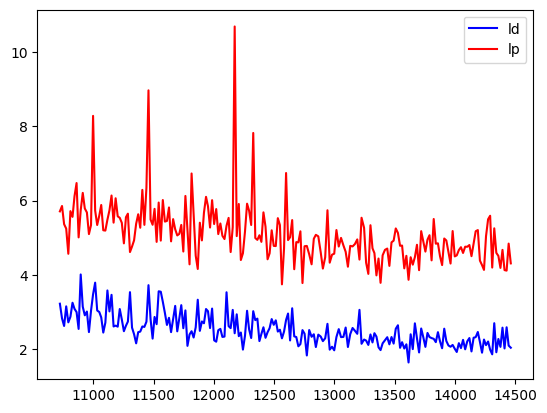

In [84]:
stride = 2
ts = np.asarray(env.ts)
lds = np.asarray(env.lds)
lps = np.asarray(env.lps)
plt.plot(ts[1000::stride], lds[1000::stride], 'b', label='ld')
plt.plot(ts[1000::stride], lps[1000::stride], 'r', label='lp')
plt.legend()
plt.show()

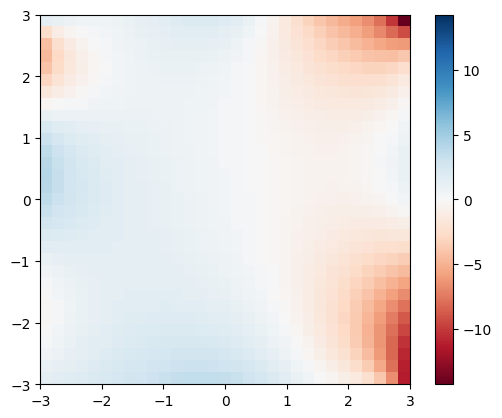

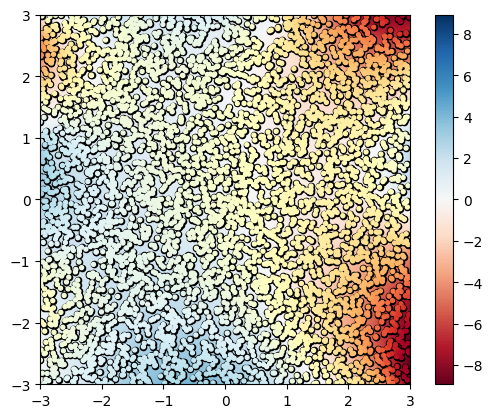

tensor(1.6862, device='cuda:0', grad_fn=<MaxBackward1>)

In [88]:
Idx = 275
g, u, p, v = ldata.get_raw_data(Idx)
g = torch.tensor(ldata.get_bc(g), dtype=torch.float32, device='cuda')
p = torch.tensor(p.T, dtype=torch.float32, device='cuda', requires_grad=True)
v = torch.tensor(v, dtype=torch.float32, device='cuda')
up = deeponet.precompute(g)

def get_vals(u, res=200):
    x = torch.linspace(*ldata.bounds,res+1)
    X,Y = torch.meshgrid(x, x, indexing='xy')
    # tensor dims: (batch, 2)
    XY = torch.stack( (X,Y) ).permute((1,2,0)).to(deeponet.device())
    vs = np.asarray(u(XY).detach().to("cpu"))
    return vs

ug = get_vals(up)
draw(u)
draw_with_points(ug, p.detach().cpu().T, v.detach().cpu())
(v-up(p)).max()

In [89]:
def eval_on_grid(u,x,y):
    X,Y = torch.meshgrid(x, y, indexing='xy')
    # tensor dims: (batch, 2)
    XY = torch.stack( (X,Y) ).permute((1,2,0)).to("cuda").requires_grad_()
    return u(XY), XY

In [90]:
def ood_g(i,j,k,l,res=30):
    g = np.zeros((res+1,res+1))
    g[0,:]  = np.sin(np.linspace(0.0, np.pi*i, res+1))
    g[-1,:] = np.sin(np.linspace(0.0, np.pi*j, res+1))
    g[:,0]  = np.sin(np.linspace(0.0, np.pi*k, res+1))
    g[:,-1] = np.sin(np.linspace(0.0, np.pi*l, res+1))
    return g

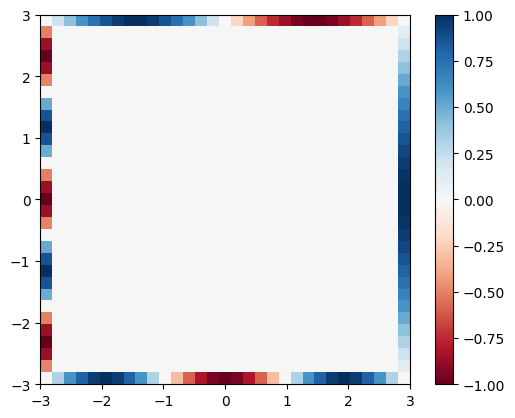

In [91]:
draw(ood_g(3,2,-5,1))

In [92]:
def draw_pred(g, res=200):
  gt = torch.tensor(ldata.get_bc(g), dtype=torch.float32, device="cuda")
  u = deeponet.precompute(gt)
  x = torch.linspace(*ldata.bounds, res+1)
  uXY, XY = eval_on_grid(u,x,x)
  lu = lapl(uXY,XY)
  draw(g)
  draw(uXY.detach().cpu())
  draw(-lu.detach().cpu())
  draw((-lu - float(ldata.c)*uXY).detach().cpu())

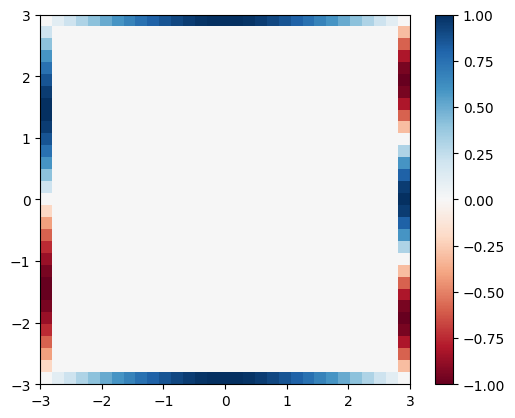

/tmp/ipykernel_76741/1870675787.py:10: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  M = np.abs(g).max()


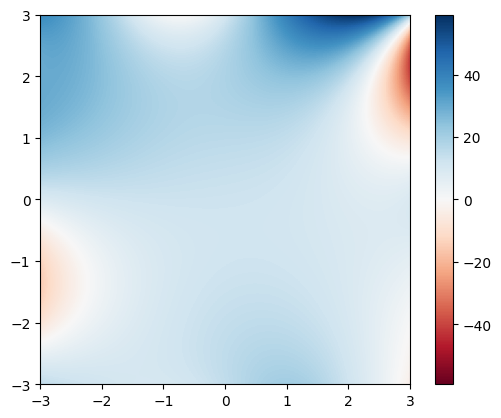

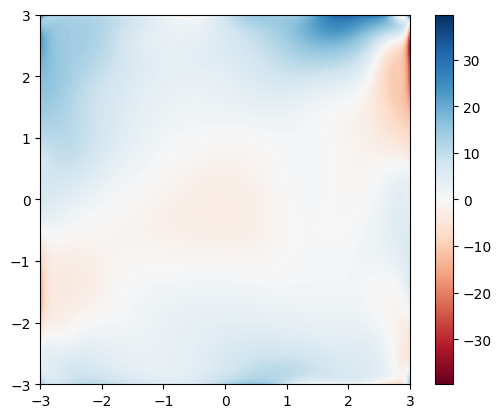

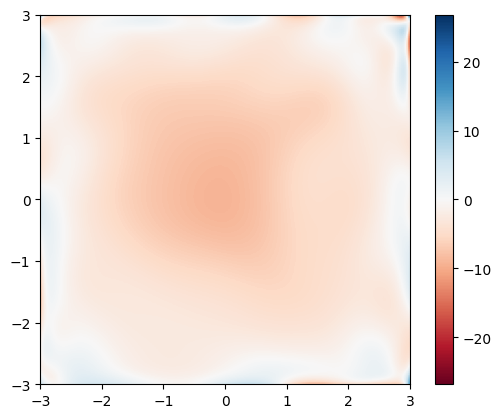

In [97]:
g = ood_g(1,1,-2,-3,res=ldata.res)
draw_pred(g)

T = 0, err = 2.2352455443737638
T = 1, err = 1.2181641256024884
T = 2, err = 0.7106320183046584
T = 3, err = 0.4157846580125598
T = 4, err = 0.24308794812016501
T = 5, err = 0.14202612654304209
T = 6, err = 0.08295059563829092
T = 7, err = 0.04843938786191039
T = 8, err = 0.028284290777985235
T = 9, err = 0.01651496084426053
T = 10, err = 0.00964280696042631
T = 11, err = 0.005630236278295738
T = 12, err = 0.0032873697389988253
T = 13, err = 0.0019194197229756005
T = 14, err = 0.0011207045114256056
T = 15, err = 0.0006543531319271972
T = 16, err = 0.0003820614380855982
T = 17, err = 0.00022307669787965684
T = 18, err = 0.0001302492405584091
T = 19, err = 7.60494694509092e-05
T = 20, err = 4.440349714675713e-05
T = 21, err = 2.5926157932213557e-05
T = 22, err = 1.513767401567818e-05
T = 23, err = 8.838531922101249e-06
T = 24, err = 5.160610961963397e-06
T = 25, err = 3.013159396369106e-06
T = 26, err = 1.7593129214838907e-06
T = 27, err = 1.0272214459135323e-06
T = 28, err = 5.997704471

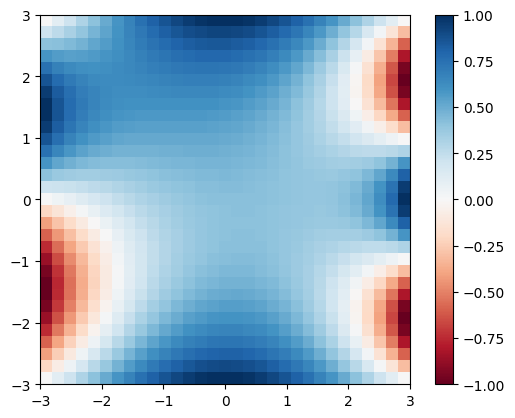

In [98]:
ue, err = ldata.solver.solve(np.zeros_like(g), g)
draw(ue)

In [99]:
def draw_basis(net, i, res = 200, draw_lapl=True):
    u = net.basis(i)
    x = torch.linspace(*ldata.bounds, res+1)
    uXY, XY = eval_on_grid(u,x,x)
    lu = lapl(uXY,XY)
    draw(uXY.detach().cpu())
    if draw_lapl:
        draw(-lu.detach().cpu())
        draw((-lu - float(ldata.c)*uXY).detach().cpu())

/tmp/ipykernel_76741/1870675787.py:10: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  M = np.abs(g).max()


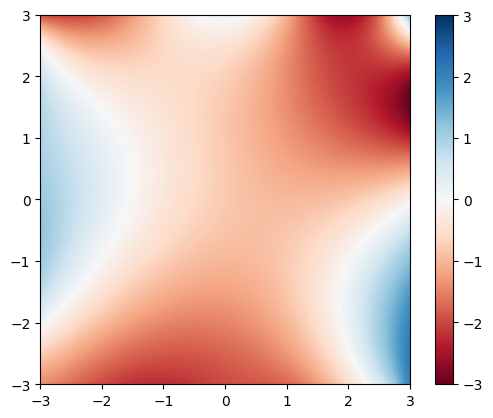

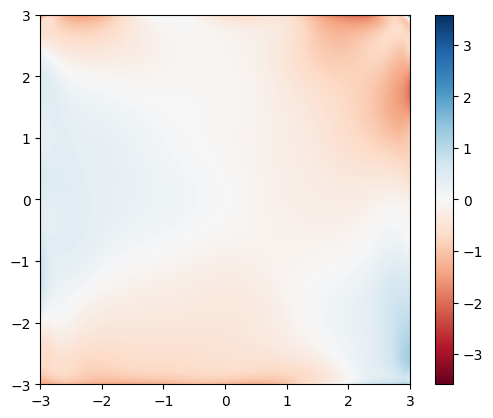

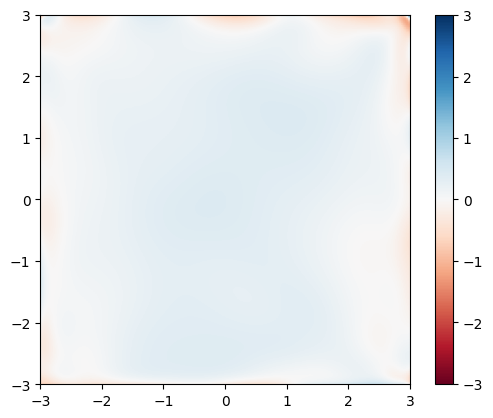

In [101]:
draw_basis(deeponet, 3)

/tmp/ipykernel_76741/822286871.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(fn2)


cp 1


/tmp/ipykernel_76741/1870675787.py:10: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  M = np.abs(g).max()


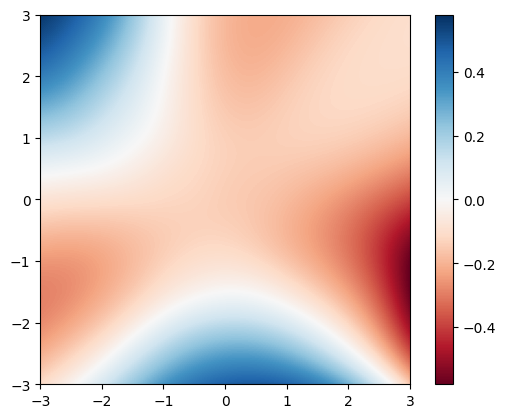

cp 2


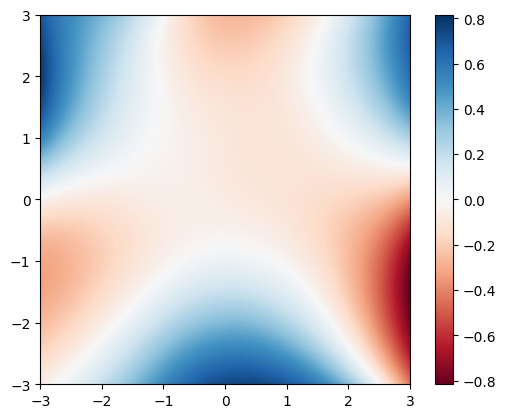

cp 3


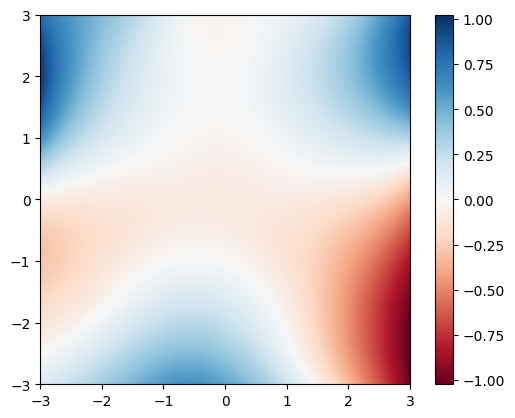

cp 4


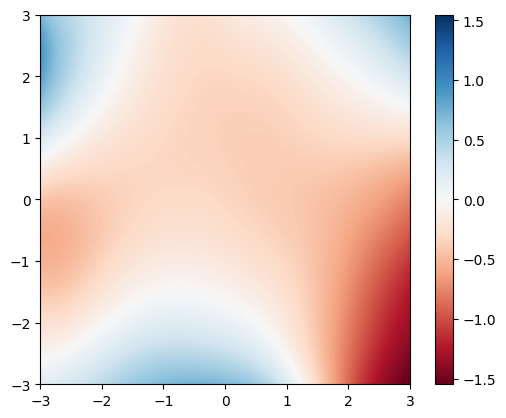

cp 5


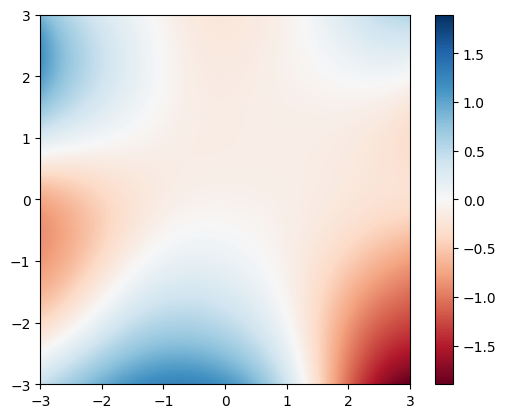

cp 6


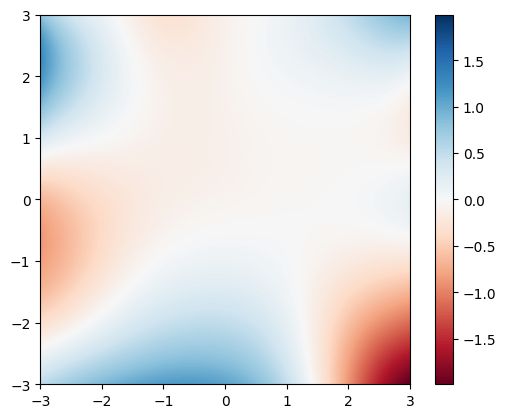

cp 7


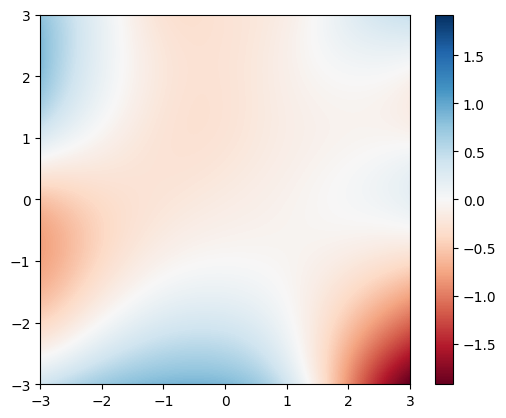

cp 8


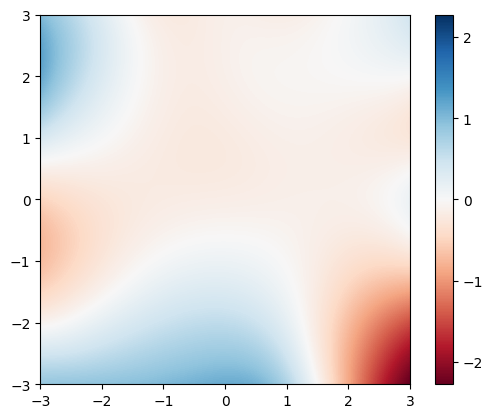

cp 9


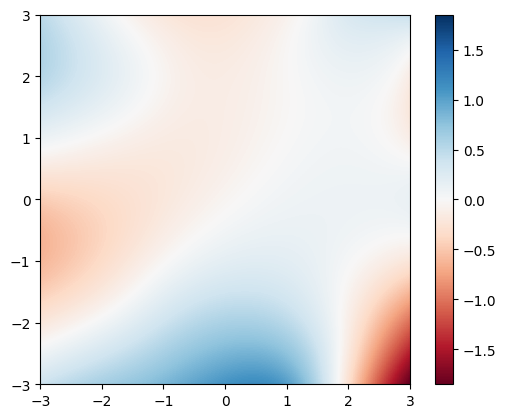

cp 10


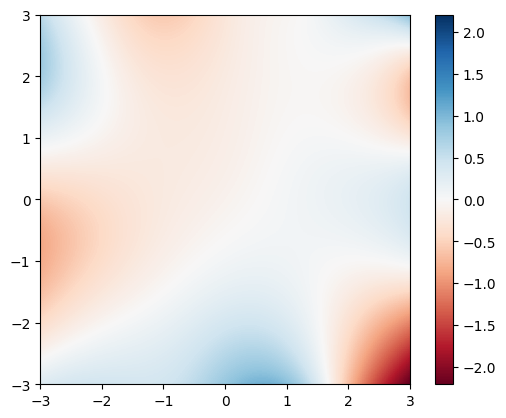

cp 11


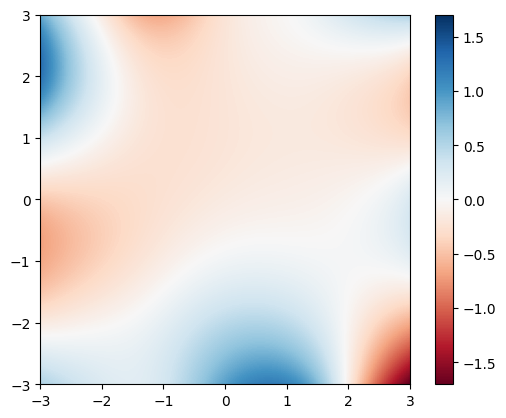

cp 12


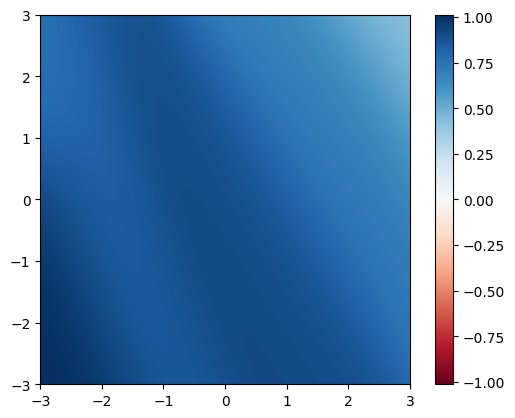

cp 13


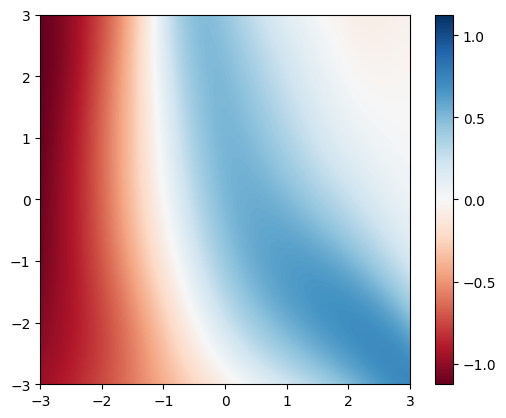

cp 14


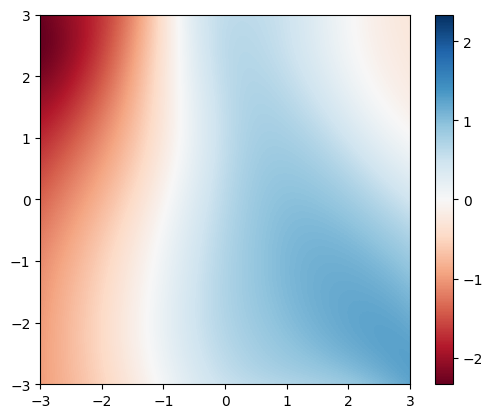

cp 15


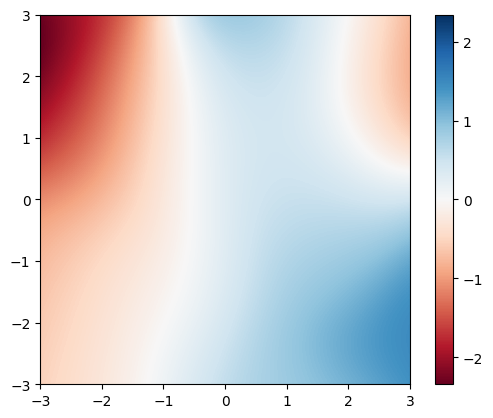

cp 16


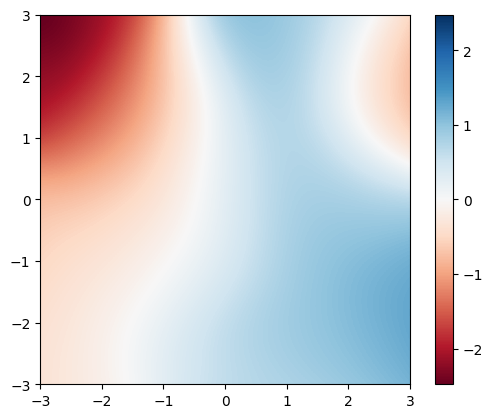

cp 17


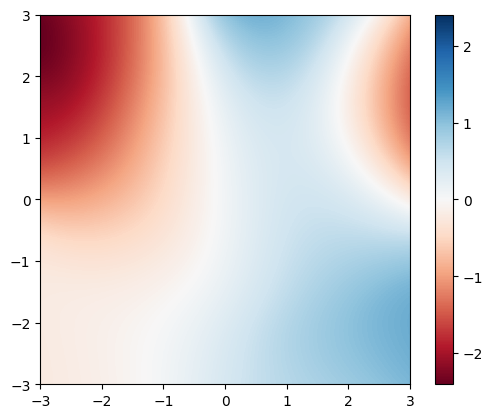

cp 18


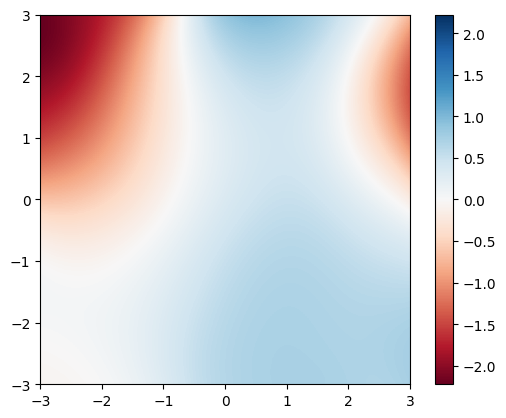

cp 19


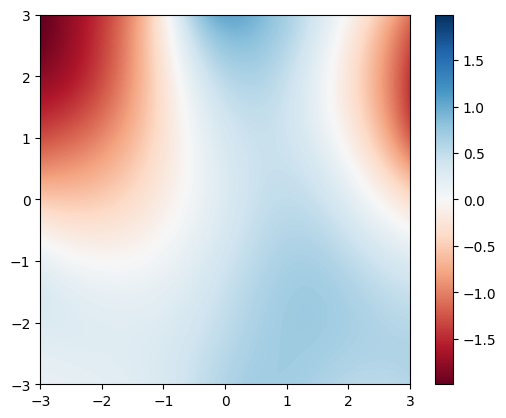

cp 20


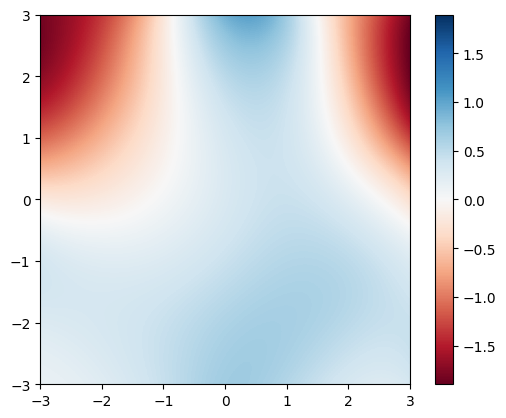

cp 21


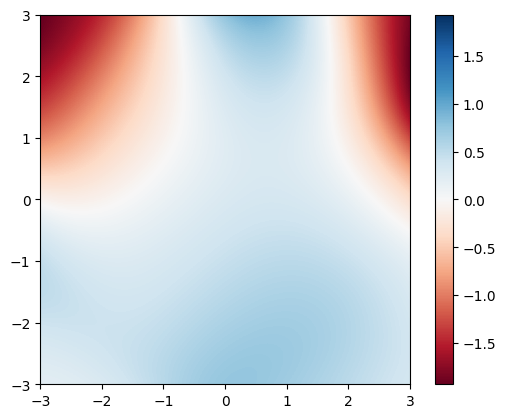

cp 22


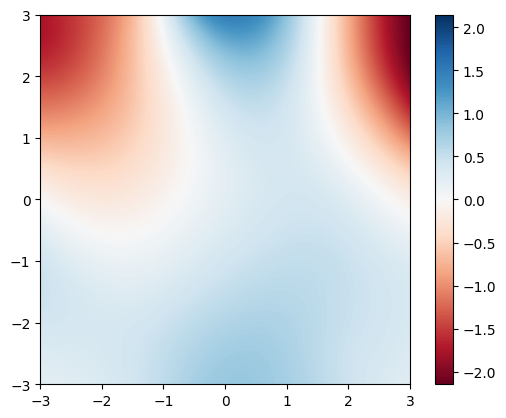

cp 23


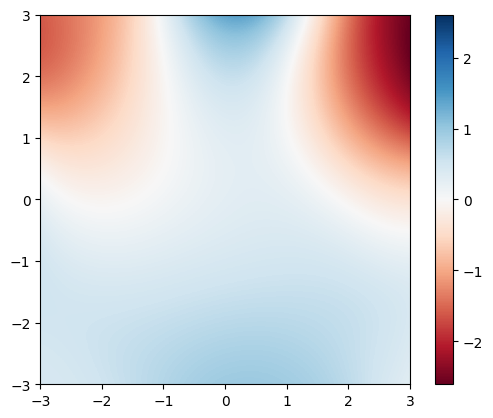

cp 24


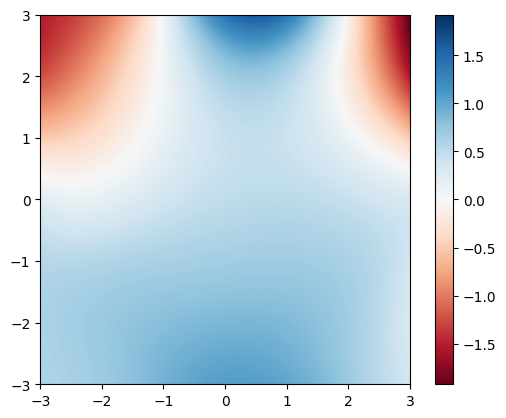

cp 25


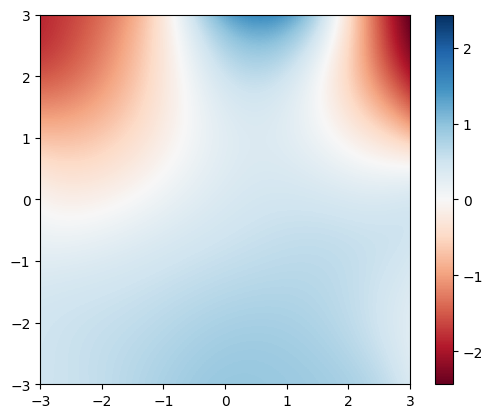

cp 26


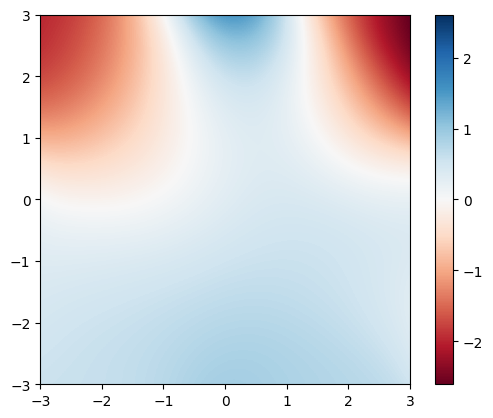

cp 27


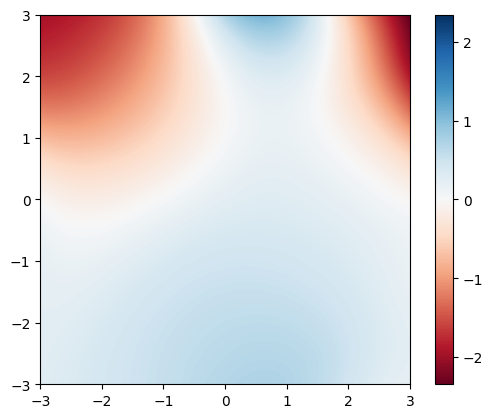

cp 28


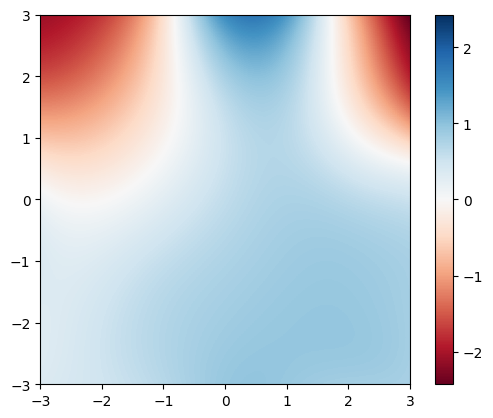

cp 29


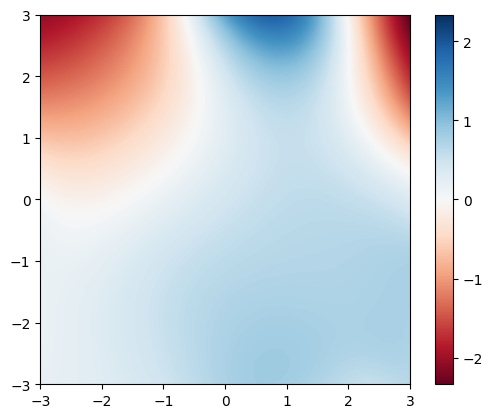

cp 30


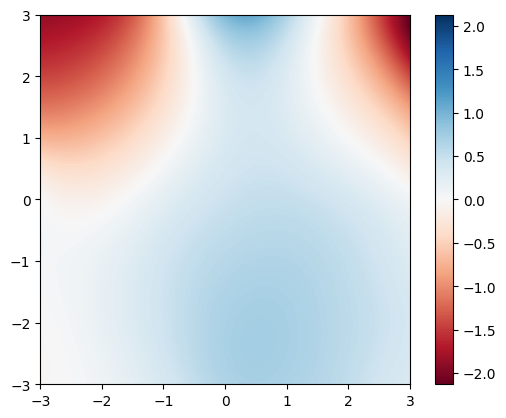

cp 31


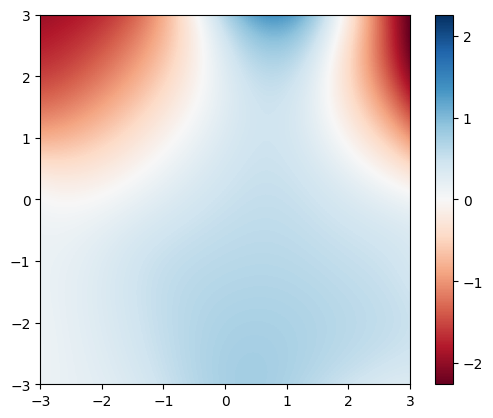

cp 32


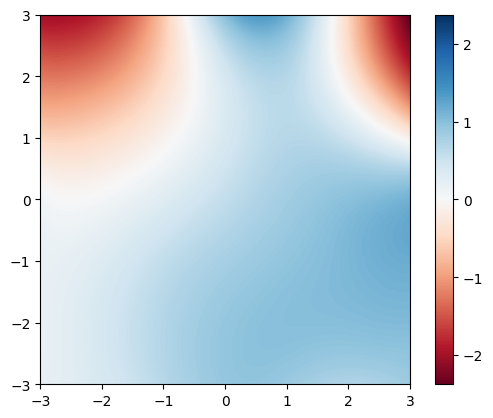

cp 33


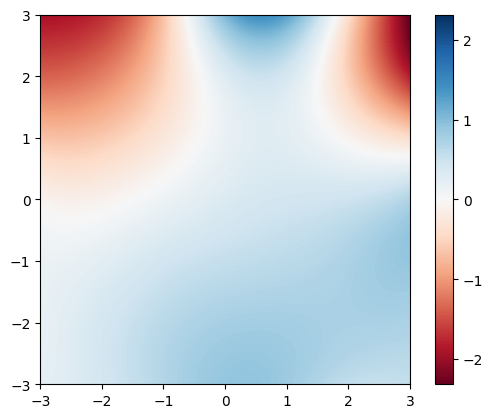

cp 34


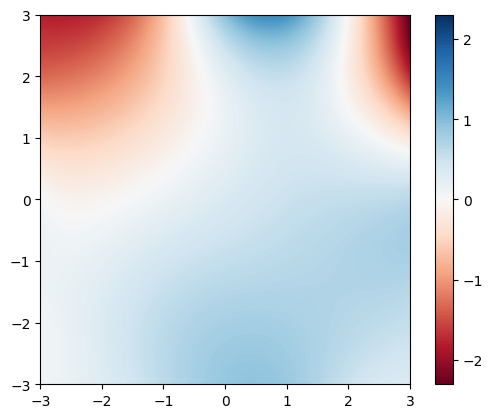

cp 35


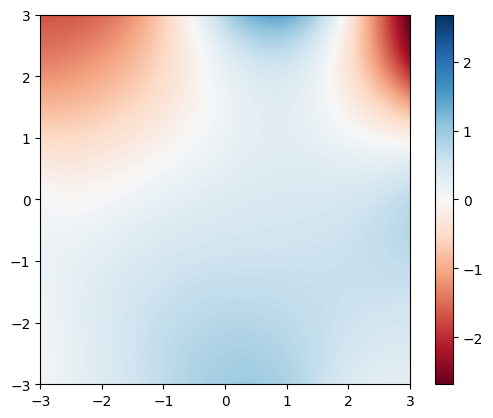

cp 36


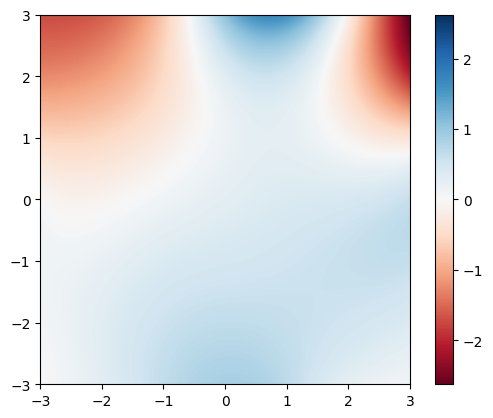

cp 37


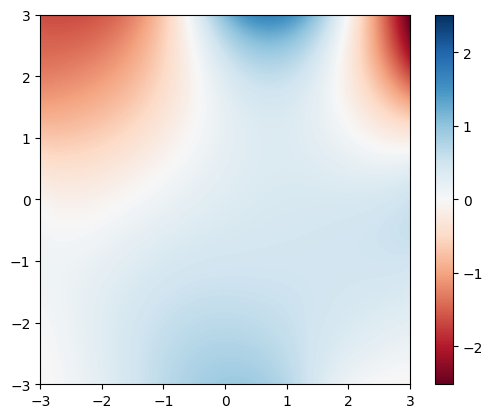

cp 38


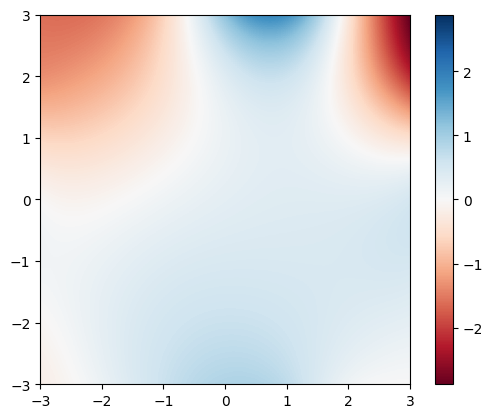

cp 39


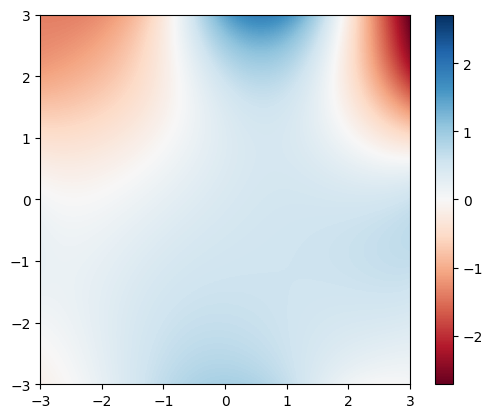

cp 40


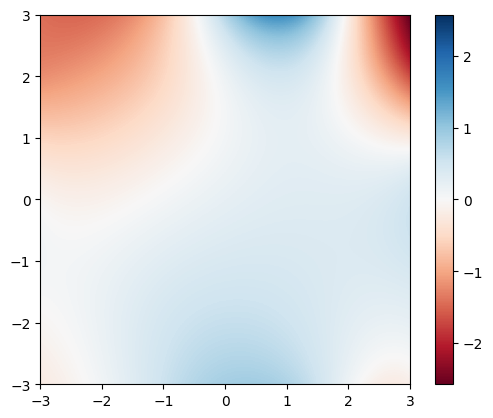

cp 41


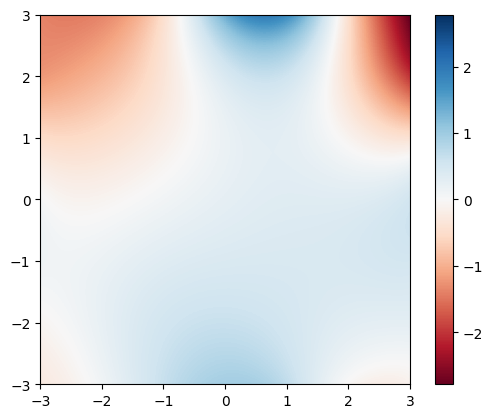

cp 42


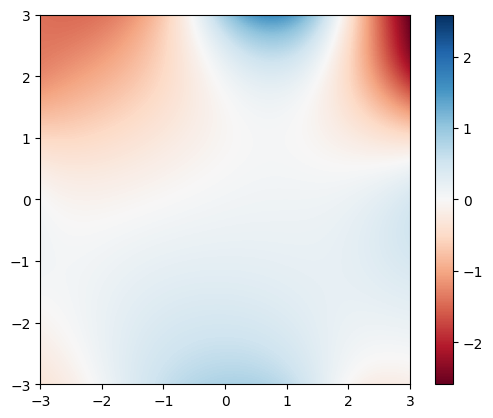

cp 43


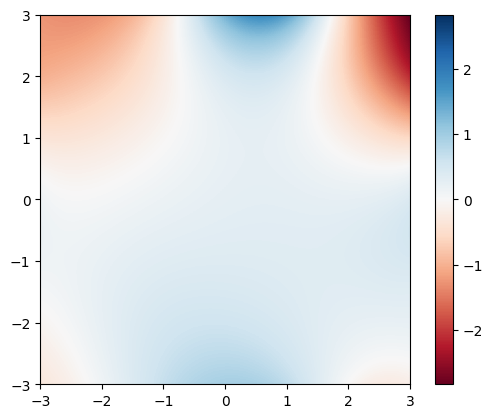

cp 44


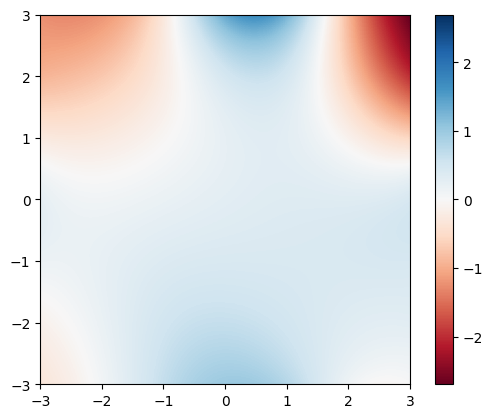

cp 45


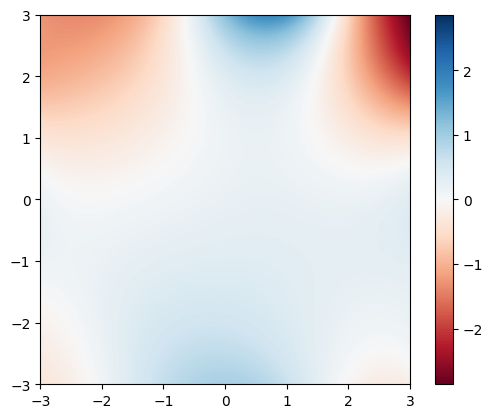

cp 46


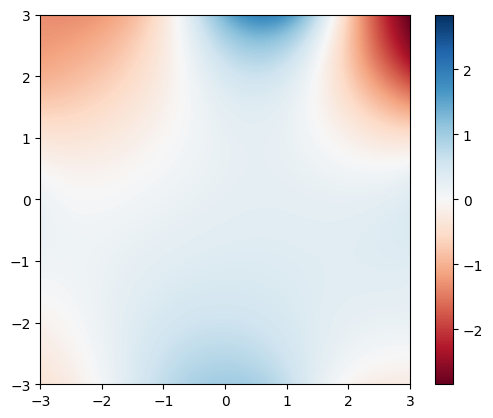

cp 47


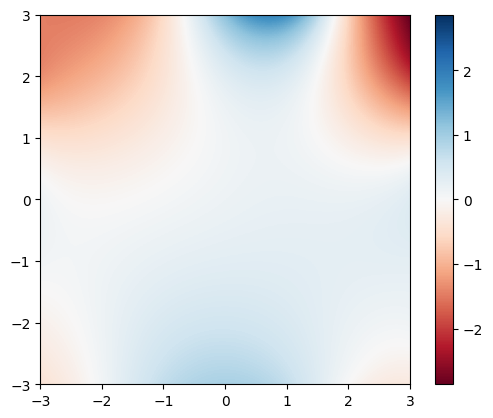

cp 48


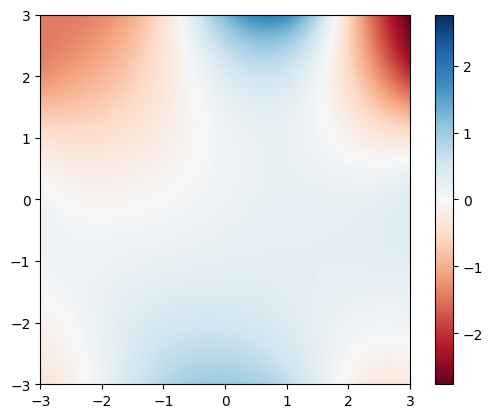

cp 49


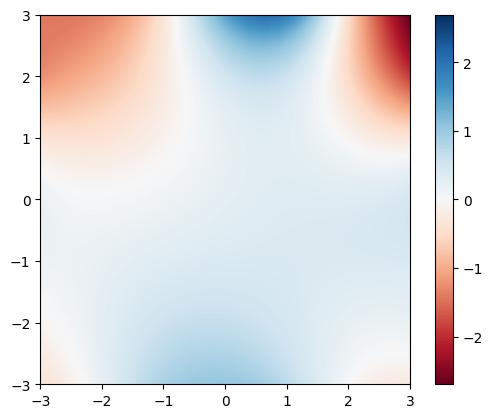

cp 50


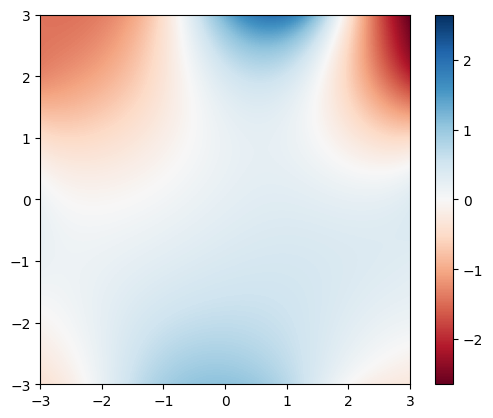

cp 51


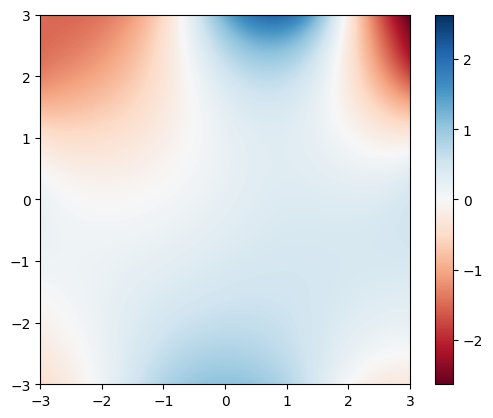

cp 52


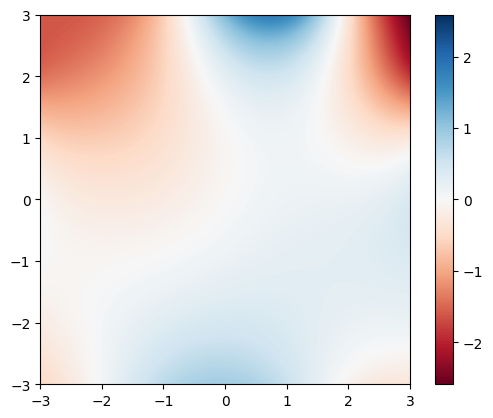

cp 53


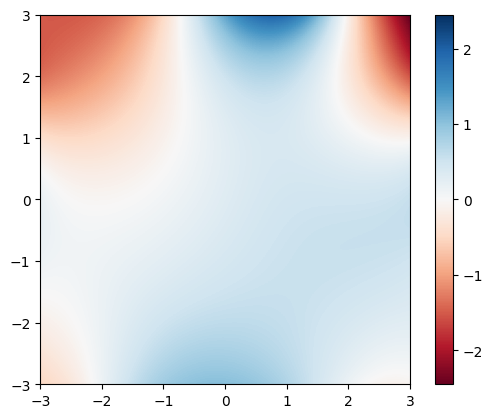

cp 54


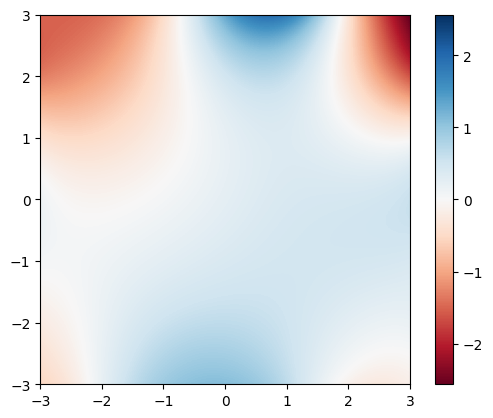

cp 55


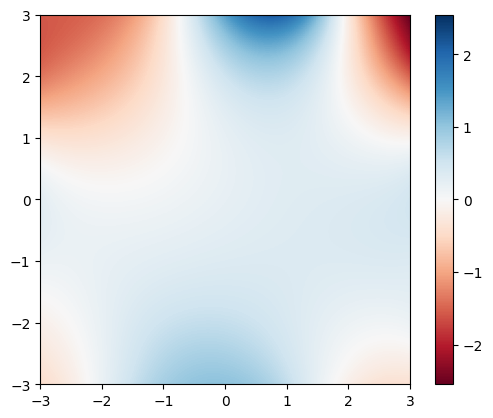

cp 56


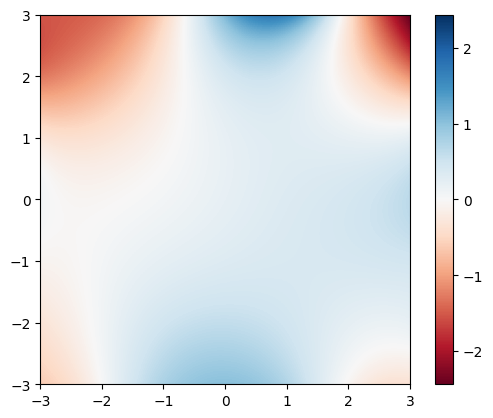

cp 57


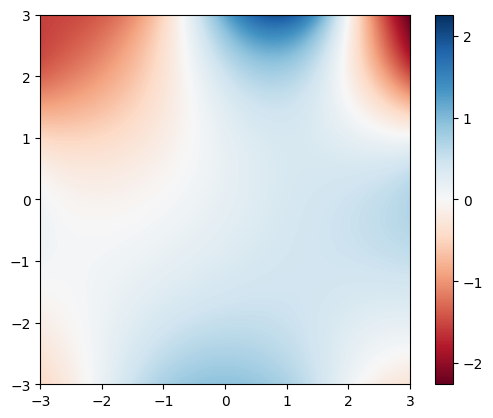

cp 58


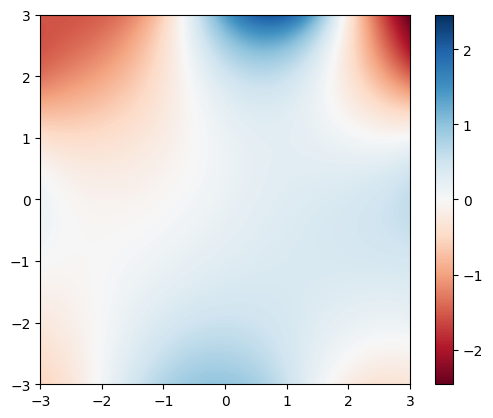

cp 59


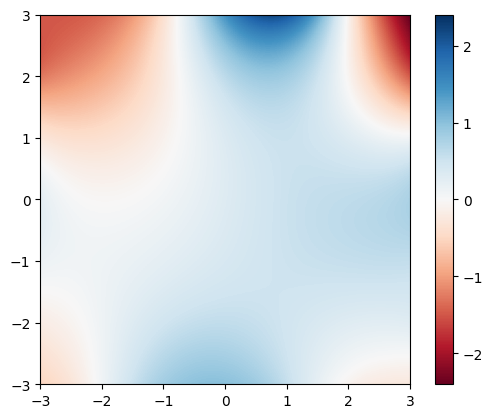

cp 60


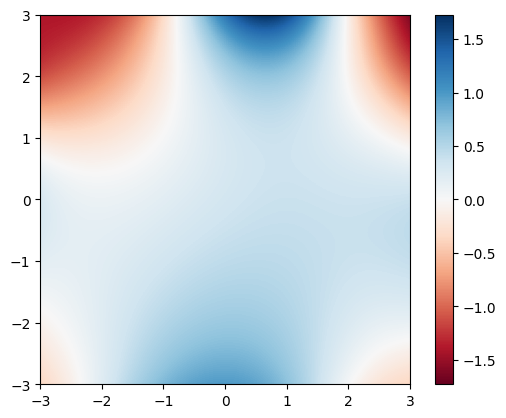

cp 61


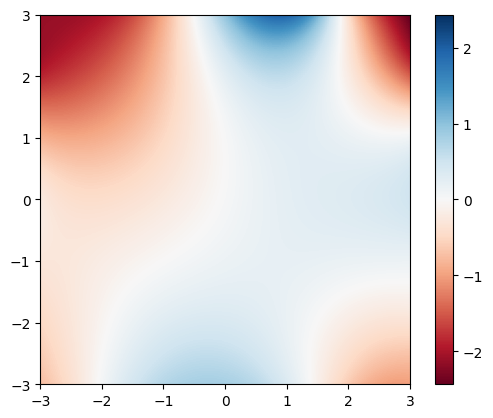

cp 62


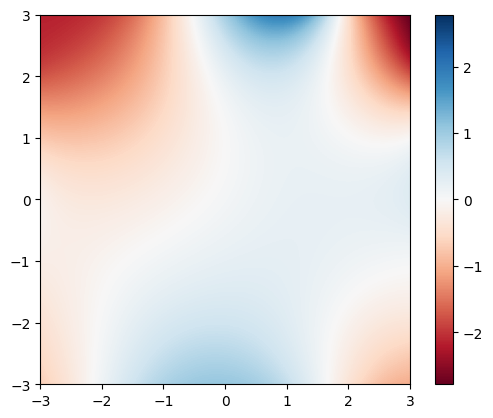

cp 63


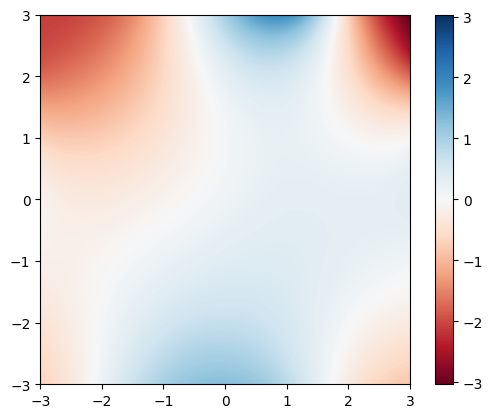

cp 64


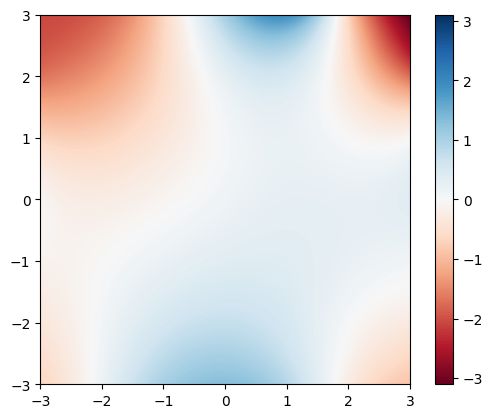

cp 65


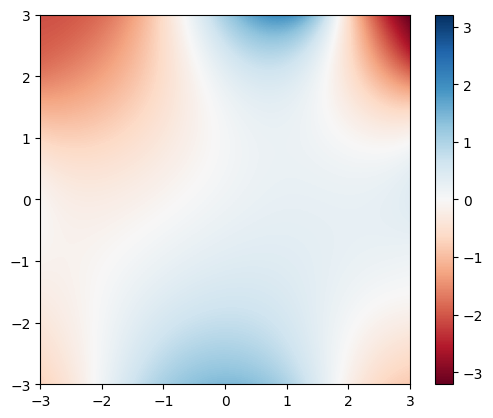

cp 66


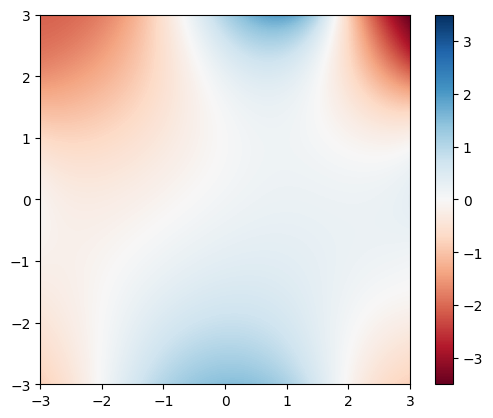

cp 67


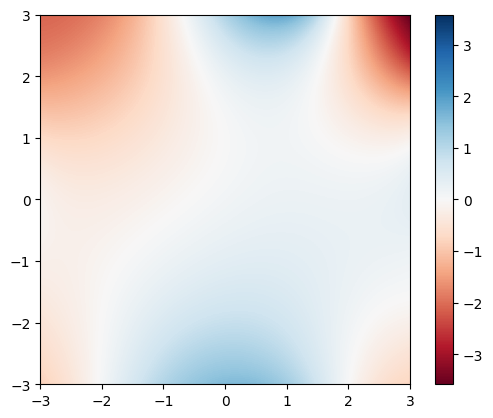

cp 68


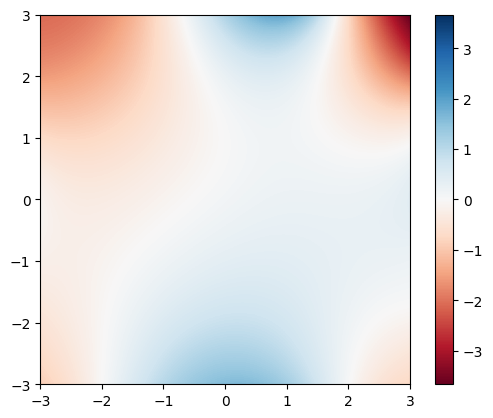

cp 69


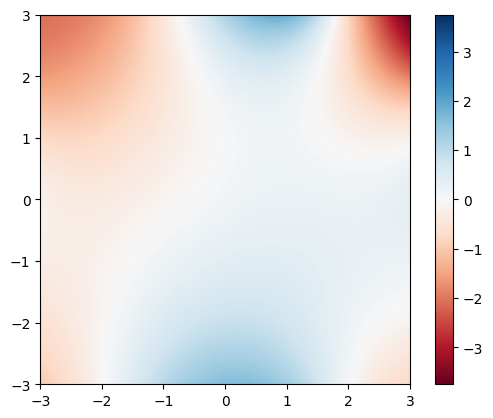

cp 70


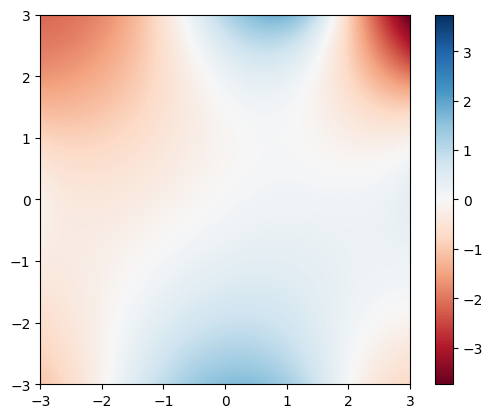

cp 71


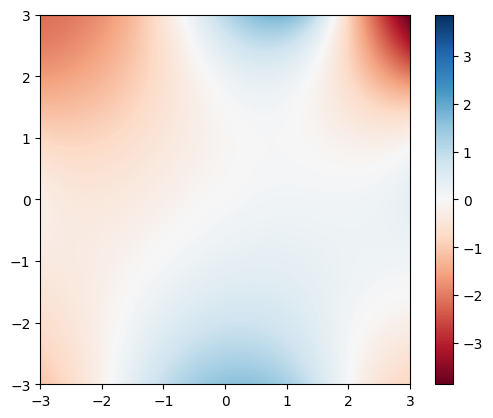

cp 72


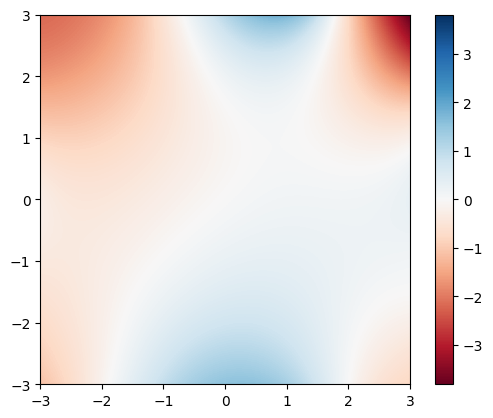

cp 73


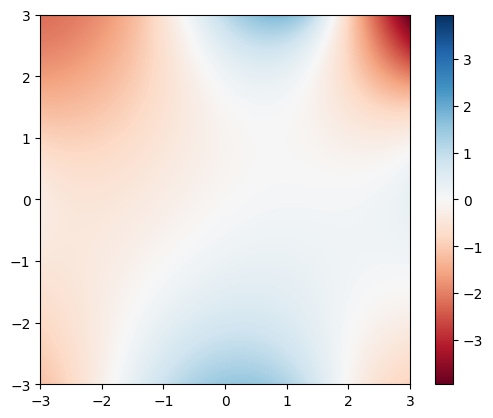

cp 74


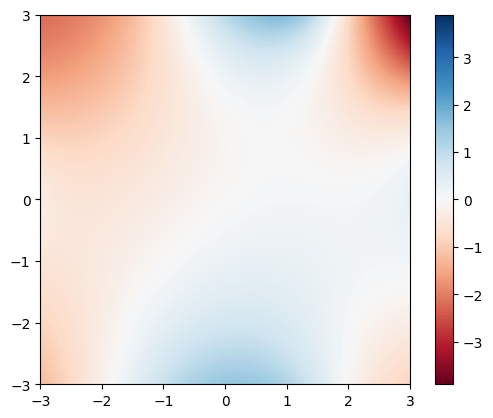

cp 75


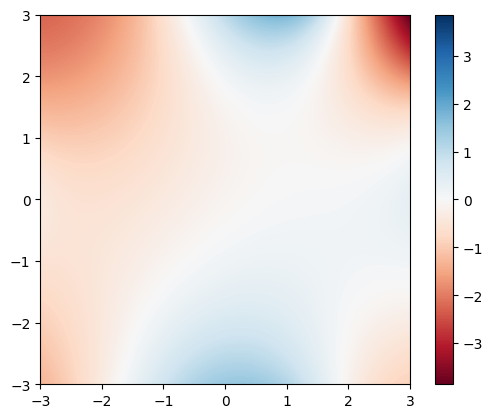

cp 76


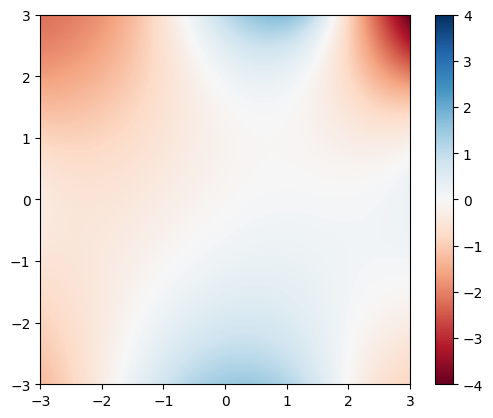

cp 77


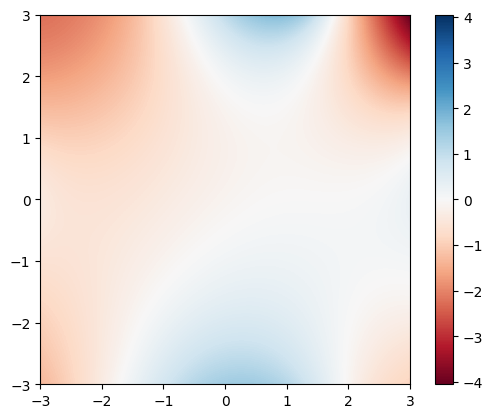

cp 78


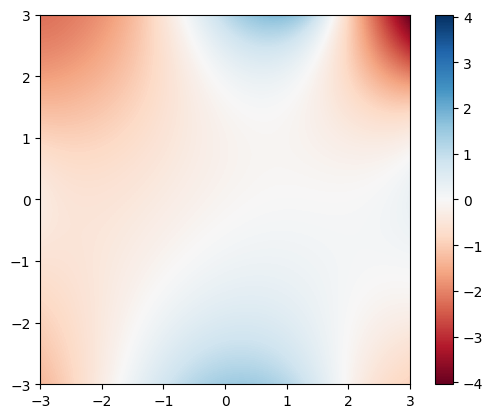

cp 79


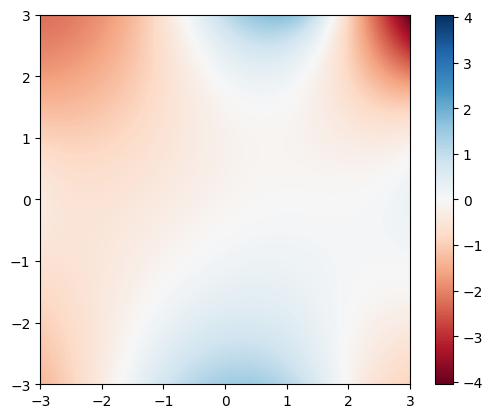

cp 80


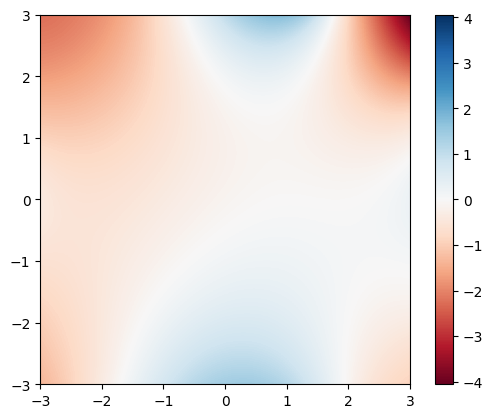

cp 81


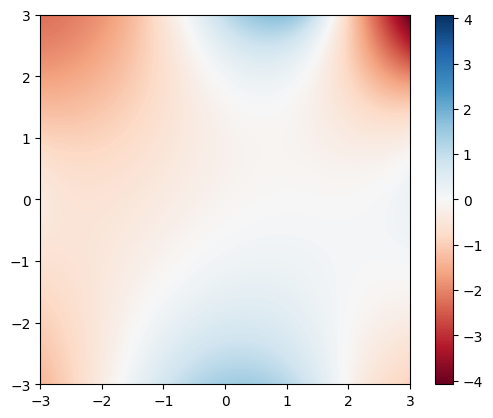

cp 82


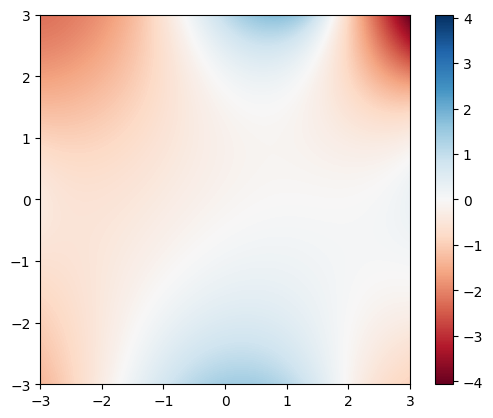

cp 83


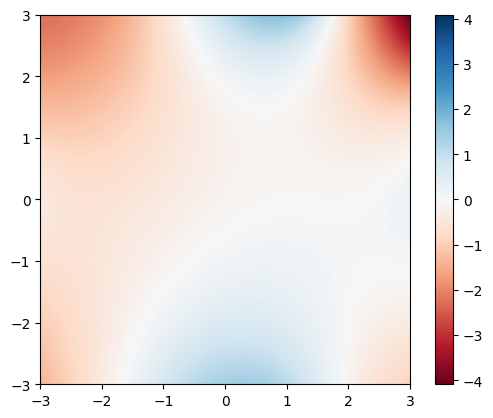

cp 84


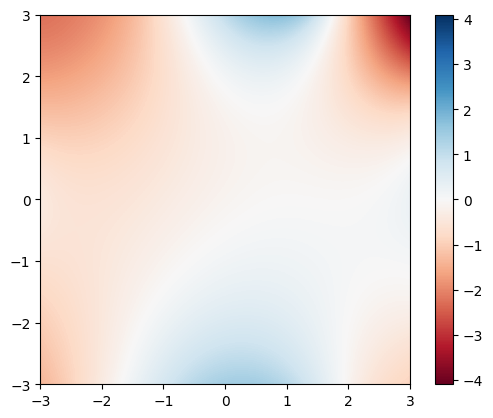

cp 85


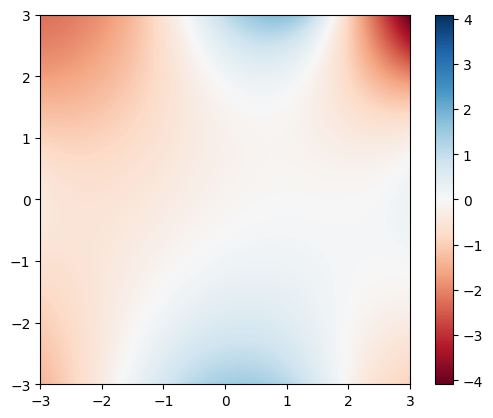

cp 86 failed


In [102]:
for cp in range(1,100):
    try:
        env.load_cp(cp)
    except:
        print("cp {} failed".format(cp))
        break
    print("cp {}".format(cp))
    draw_basis(env.model, 4, draw_lapl=False)